In [1]:
import pickle
import random
import math
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_boston
from datetime import datetime
from datetime import timedelta
%matplotlib inline
# plt.matplotlib.rcParams.update({'font.size': 50})
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'   
plt.rcParams["patch.force_edgecolor"] = False
plt.rc('figure', titlesize=25)

In [924]:
CONF_PATH = '../augmented_datasets/pickles/final_data/hopkins_conf_narrow_0605.pkl'
DEATH_PATH = '../augmented_datasets/pickles/final_data/hopkins_death_narrow_0605.pkl'
OUTLIER_QUARTILES = (0.02, 0.98) # Min, max quartiles

In [925]:
def remove_outlier(df, range_, columns):
    if range_ == (0,0):
        return df
    low = range_[0]
    high = range_[1]
    qnt = df.quantile([low, high])
    data = df.copy()
    for col in list(columns):
        data[col] = \
            data[(data[col] > qnt.loc[low, col]) &\
               (data[col] < qnt.loc[high, col])][col]
    return data.dropna()

def calc_corrs_scatter(df, outliers=(0,0), gdp_thr=0, urb_thr=0, only_us=False,\
                       show_names=False, show_states=False, temp_outliers=(0,0),
                      gdp_outlier=(0,0), urb_outlier=(0,0), mob_outlier=(0,0),
                      tpc_outlier=(0,0), plot=False, print_=False, return_p=False):

    values = []
    p_values = {}
    targets = ['GF_Q1', 'GF_Q2', 'GF_Q3', 'adj_gf']
    
    for target in targets:
        
        # Process outliers
        if outliers == (0,0):
            confs1 = df.copy()
        else:
            confs1 = remove_outlier(df, outliers, [target])
        if only_us:
            confs1 = confs1[confs1['Country_Region'] == 'US']
        if temp_outliers != (0,0):
            confs1 = remove_outlier(confs1, temp_outliers, ['avg_interval_tmp'])
        if gdp_outlier != (0,0):
            confs1 = remove_outlier(confs1, gdp_outlier, ['GDP'])
        if urb_outlier != (0,0):
            confs1 = remove_outlier(confs1, urb_outlier, ['Urbanization'])
        if mob_outlier != (0,0):
            confs1 = remove_outlier(confs1, mob_outlier, ['avg_mobility'])
        if tpc_outlier != (0,0):
            confs_us = confs1[confs1['Country_Region'] == 'US'].copy()
            confs_not_us = confs1[confs1['Country_Region'] != 'US'].copy()
            confs_us = remove_outlier(confs_us, tpc_outlier, ['Tests \\ Pop'])
            confs_not_us = remove_outlier(confs_not_us, tpc_outlier, ['Tests per 1M'])
#             confs1 = pd.concat(confs_us, confs_not_us)
            confs1 = confs_us.append(confs_not_us)
#         confs1.dropna(inplace=True)
        confs1 = confs1[confs1['GDP'] > gdp_thr]
        confs1 = confs1[confs1['Urbanization'] > urb_thr]
        try:
            gf = confs1[target].loc[:,'data'].values.tolist()
        except KeyError:
            print('skipped {0}'.format(target))
            continue
        avg_int_tmp = confs1['avg_interval_tmp'].loc[:,'data'].values.tolist()

        corr_p1 = stats.pearsonr(gf, avg_int_tmp)
        corr_s1 = stats.spearmanr(gf, avg_int_tmp)
        
        if print_:
            print('Interval temp vs {0} correlations'.format(target))
            print('n={0}'.format(len(gf)))
            print('Pearson: {0}\tOne sided p_value: {1}'.format(corr_p1[0], corr_p1[1] / 2))
            print('Spearman: {0}\tOne sided p_value: {1}\n'.format(corr_s1[0], corr_s1[1] / 2))
        values.append(corr_p1[0]+corr_s1[0])
        p_values[target] = (corr_p1[1] / 2, corr_s1[1] / 2)
        
    if plot:
        if outliers == (0,0):
            confs1 = df.copy()
        else:
            confs1 = remove_outlier(df, outliers, ['GF_Q1'])
        if only_us:
            confs1 = confs1[confs1['Country_Region'] == 'US']
        if temp_outliers != (0,0):
            confs1 = remove_outlier(confs1, temp_outliers, ['avg_interval_tmp'])
        if gdp_outlier != (0,0):
            confs1 = remove_outlier(confs1, gdp_outlier, ['GDP'])
        if urb_outlier != (0,0):
            confs1 = remove_outlier(confs1, urb_outlier, ['Urbanization'])
        if mob_outlier != (0,0):
            confs1 = remove_outlier(confs1, mob_outlier, ['avg_mobility'])
        if tpc_outlier != (0,0):
            confs_us = confs1[confs1['Country_Region'] == 'US'].copy()
            confs_not_us = confs1[confs1['Country_Region'] != 'US'].copy()
            confs_us = remove_outlier(confs_us, tpc_outlier, ['Tests \\ Pop'])
            confs_not_us = remove_outlier(confs_not_us, tpc_outlier, ['Tests per 1M'])
            confs1 = pd.concat(confs_us, confs_not_us)
        confs1.dropna(inplace=True)
        confs1 = confs1[confs1['GDP'] > gdp_thr]
        confs1 = confs1[confs1['Urbanization'] > urb_thr]      
        gf_q1_1 = confs1['GF_Q1'].loc[:,'data'].values.tolist()
        avg_int_tmp1 = confs1['avg_interval_tmp'].loc[:,'data'].values.tolist()

        fig, axes = plt.subplots(figsize=(15, 7))
        _ = axes.scatter(avg_int_tmp1, gf_q1_1)
        n = len(gf_q1_1)

        _ = axes.set_xlabel('avg interval temp')
        _ = axes.set_ylabel('Q1 GF')
        _ = axes.set_title('n={0}'.format(n))

        if show_names:
            countries1 = confs1['Country_Region'].loc[:,'data'].values.tolist()
            for i, txt in enumerate(countries1):
                _ = axes.annotate(txt, (avg_int_tmp1[i], gf_q1_1[i]))

        if show_states and not show_names:
            states1 = confs1['Province_State'].loc[:,'data'].values.tolist()
            for i, txt in enumerate(states1):
                _ = axes.annotate(txt, (avg_int_tmp1[i], gf_q1_1[i]))

    if return_p:
        return p_values
    else:
        return np.average(values)

def fdr(df, urb_gdp_thrshs, p, target, spearman=False, features=['GDP', 'Urbanization']):
    """
    Calculates pearson and spearman fdr for urb and gdp thrsholds
    """
    if (0,0) in urb_gdp_thrshs:
        _ = urb_gdp_thrshs.pop(urb_gdp_thrshs.index((0,0)))
    N = len(urb_gdp_thrshs)
    p_pearson = np.zeros(N)
    p_spearman = np.zeros(N)
    i = 0

    for trsh in urb_gdp_thrshs:
        confs1 = df.copy()
        confs1 = remove_outlier(confs1, trsh, features)
        try:
            gf = confs1[target].loc[:,'data'].values.tolist()
        except KeyError:
            print('skipped {0}'.format(trsh))
            N = N - 1
            continue
        avg_int_tmp = confs1['avg_interval_tmp'].loc[:,'data'].values.tolist()
        p_pearson[i] = (stats.pearsonr(gf, avg_int_tmp)[1] / 2) - 1e20
        p_spearman[i] = (stats.spearmanr(gf, avg_int_tmp)[1] / 2) - 1e20
        i += 1
    
    if spearman:
        return p * N / len(p_spearman[p_spearman <= p])
    else:
        return p * N / len(p_pearson[p_pearson <= p])
        
def manual_WRS(gf_qx, df, temp_range):

    colds = df[df['avg_interval_tmp'] <= temp_range[0]]\
        [[gf_qx]]

    hots = df[df['avg_interval_tmp'] >= temp_range[1]]\
        [[gf_qx]]

    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)

    colds.rename(columns={gf_qx: ''}, inplace=True)
    hots.rename(columns={gf_qx: ''}, inplace=True)

    # manual WRS algorithm

    colds = colds.T
    hots = hots.T
    colds = colds.add_prefix('c')
    hots = hots.add_prefix('h')
    ranks = colds.join(hots, lsuffix='first').rank(axis=1)
    
    h_list = [sample for sample in ranks.columns if 'h' in sample]
    c_list = [sample for sample in ranks.columns if 'c' in sample]
    h_sum = ranks[h_list].sum(axis=1)
    c_sum = ranks[c_list].sum(axis=1)

    b = len(colds.columns)
    n = b + len(hots.columns)
    expected_cold_sum = (b * (n + 1)) / 2
    sigma = math.sqrt(b * (n - b) * (n + 1) / 12)

    sums_normal = stats.norm(loc=expected_cold_sum, scale=sigma)
    p_value = 1 - sums_normal.cdf(float(c_sum))
    
    size = {
           'colds': b,
           'hots': len(hots.columns)
           }
    
    return {'expected': expected_cold_sum, 
            'attained': c_sum, 
            'p': p_value, 
            'sigma': sigma, 
            'size': size}

def print_manual_WRS(qx, qx_results):
    difference = qx_results[1] - qx_results[0]
    print('--------------------------------------------------')
    print('{} WRS (manual)'.format(qx))
    print('--------------------------------------------------')
    print(
         '# colds samples: {0}\n# of hots samples: {1}\n'
         'Expected mean for cold countries rank sum: {2}\n'
         'Attained mean for cold countries rank sum: {3}\n'
         'Sigma: {4}\n'
         '(Attained mean) - (Expected mean) = {5}\n'
         'p-value for this result is: {6}'
         .format(qx_results[4]['colds'], qx_results[4]['hots'], qx_results[0],\
                 qx_results[1], difference, qx_results[3], qx_results[2]))

def builtin_WRS(gf_qx, df, temp_range):
    colds = df[df['avg_interval_tmp'] <= temp_range[0]][gf_qx]
    hots = df[df['avg_interval_tmp'] >= temp_range[1]][gf_qx]
    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)
    t, p = stats.ranksums(colds, hots)
    size = {
           'colds': len(colds),
           'hots': len(hots)
           }
    return {'t':t, 
            'p':p, 
            'size':size}

def print_builtin_WRS(qx, qx_results):
    print('--------------------------------------------------')
    print('{} WRS (built-in) '.format(qx))
    print('--------------------------------------------------')
    print('Statistic:\t{0}'.format(qx_results[0]))
    print('p-value:\t{0}'.format(qx_results[1]))
#     print('--------------------------------------------------')


def builtin_ttest(gf_qx, df, temp_range):
    colds = df[df['avg_interval_tmp'] <= temp_range[0]][gf_qx]
    hots = df[df['avg_interval_tmp'] >= temp_range[1]][gf_qx]
    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)
    t, p = stats.ttest_ind(colds, hots)
    size = {
           'colds': len(colds),
           'hots': len(hots)
           }
    return {'t':t, 
            'p':p, 
            'size':size}


def print_builtin_ttest(qx, qx_results):
    print('--------------------------------------------------')
    print('{} TTest (built-in)'.format(qx))
    print('--------------------------------------------------')
    print('# colds: {0}\n# of hots: {1}'.format(qx_results[2]['colds'], qx_results[2]['hots']))
    print('Statistic:\t{0}'.format(qx_results[0]))
    print('p-value:\t{0}'.format(qx_results[1]))
    print('--------------------------------------------------')

def calc_wrs_ttest(df, temp_range):
    Q1_manual = manual_WRS('GF_Q1', df, temp_range)
    print_manual_WRS('Q1', Q1_manual)

    Q1_builtin = builtin_WRS('GF_Q1', df, temp_range)
    print_builtin_WRS('Q1', Q1_builtin)
    
    Q1_ttest = builtin_ttest('GF_Q1', df, temp_range)
    print_builtin_ttest('Q1', Q1_ttest)
    
#     Q3_manual = manual_WRS('GF_Q3', df)
#     print_manual_WRS('Q3', Q3_manual)

#     Q3_builtin = builtin_WRS('GF_Q3', df)
#     print_builtin_WRS('Q3', Q3_builtin)

#     Q3_ttest = builtin_ttest('GF_Q3', df)
#     print_builtin_ttest('Q3', Q3_ttest)     

In [954]:
hopkins_confirmed = pd.read_pickle(CONF_PATH)
hopkins_death = pd.read_pickle(DEATH_PATH)

hopkins_confirmed.drop((37.0902, -95.7129), level=0, inplace=True)
hopkins_death.drop((37.0902, -95.7129), level=0, inplace=True)

hopkins_confirmed.drop(columns='Total Tests', inplace=True)
hopkins_confirmed.drop(columns='State Population', inplace=True)
hopkins_confirmed['Democracy'] = hopkins_confirmed['Democracy'].fillna(hopkins_confirmed['Democracy'].mean())
hopkins_confirmed['Tests \\ Pop'] = hopkins_confirmed['Tests \\ Pop'].fillna(0)
hopkins_confirmed['first_7'].dropna(inplace=True)
hopkins_confirmed['GDP'].dropna(inplace=True)
hopkins_confirmed['Urbanization'].dropna(inplace=True)

hopkins_death.drop(columns='Total Tests', inplace=True)
hopkins_death.drop(columns='State Population', inplace=True)
hopkins_death['Democracy'] = hopkins_death['Democracy'].fillna(hopkins_death['Democracy'].mean())
hopkins_death['Tests \\ Pop'] = hopkins_death['Tests \\ Pop'].fillna(0)
hopkins_death['first_7'].dropna(inplace=True)
hopkins_death['GDP'].dropna(inplace=True)
hopkins_death['Urbanization'].dropna(inplace=True)

hopkins_confirmed.dropna(inplace=True)

Add adjusted gf and set 1M tests to US

In [955]:
hopkins_confirmed.insert(2, 'adj_gf', np.nan)
hopkins_death.insert(2, 'adj_gf', np.nan)
hopkins_confirmed['adj_gf'] = ( (10**10) * hopkins_confirmed['GF_Q1']) / \
                             ((hopkins_confirmed['Median Age']) * hopkins_confirmed['Gini Index']\
                              * hopkins_confirmed['Democracy'] * (hopkins_confirmed['Tests per 1M']))
hopkins_death['adj_gf'] = (1000 * hopkins_death['GF_Q3'] * hopkins_death['GDP']) / \
                         ((hopkins_death['Median Age']**2) * hopkins_death['Gini Index'] * hopkins_death['Democracy'])
# Transpose Tests \\ pop to Test \\ million in US
hopkins_confirmed['Tests \\ Pop'] = hopkins_confirmed['Tests \\ Pop'] * 1e6

### Multiple testing
Multiple testing for gdp, mobility, tests per capita \ million and urbanization

In [956]:
# Change these two hyper parameters to control outlier and confirmed \ death data
OUTLIERS = (0.02, 0.98)
TEMP_OUTLIERS = (0, 0)
DATA = hopkins_confirmed
K = 10 # num of top scores presented
QUANTILES = \
            [(0.1,0.3), (0.1,0.4), (0.1,0.5), (0.1,0.6),(0.1,0.7), (0.1,0.8), (0.1, 0.9), (0.1,1)] +\
            [(0.2,0.4), (0.2,0.5), (0.2,0.6), (0.2,0.7), (0.2,0.8), (0.2,0.9), (0.2,1)] +\
            [(0.3,0.5), (0.3,0.6), (0.3,0.7), (0.3,0.8), (0.3,0.9), (0.3,1)] +\
            [(0.4,0.7), (0.4,0.8), (0.4,0.9), (0.4,1)] +\
            [(0.5,0.8), (0.5,0.9), (0.6,1)] +\
            [(0.6,0.9), (0.6,1)] +\
            [(0.7,1), (0.8,1), (0.9,1), (0,0)]

MINI_QUANTILES = [(0.01,0.99), (0.02,0.98), (0.03,0.97), (0.04,0.96), (0.05,0.95),\
                 (0.06,0.94), (0.07,0.93), (0.08,0.92), (0.09,0.91), (0.1,0.9)]

TEMPS = [(0,0), (0.4,0.6), (0.3,0.7), (0.2,0.8), (0.1,0.9), (0.05, 0.95)]

FEATURES = ['GDP', 'Urbanization', 'avg_interval_tmp',\
                                     'GF_Q1', 'GF_Q2', 'GF_Q3']

coords = list(set(hopkins_confirmed.index.get_level_values(0)))
EURO_COORDS = [coord for coord in coords if (coord[0] > 36.7 and coord[1] > -16 and coord[1] < 25)]
EURO_DF = hopkins_confirmed.loc[EURO_COORDS, :, :].copy()
NO_US_DF = hopkins_confirmed[hopkins_confirmed['Country_Region'] != 'US']

###### Setting 0 - Global

GDP AND URB

In [957]:
results = pd.Series(index=QUANTILES)
for qnt in QUANTILES:
    d = remove_outlier(DATA, qnt, ['GDP', 'Urbanization'])
    results.loc[[qnt]] = (calc_corrs_scatter(d, outliers=OUTLIERS, only_us=False, temp_outliers=TEMP_OUTLIERS))
print('combined avg scores (pearson + spearman)\n'
      'No outlier: {0}\n'
      'Top {1}:\n{2}'
      .format(results[[(0,0)]], K, results.sort_values()[0:K]))

combined avg scores (pearson + spearman)
No outlier: (0, 0)   -0.067958
dtype: float64
Top 10:
(0.3, 0.6)   -0.356271
(0.3, 0.7)   -0.318726
(0.3, 0.8)   -0.306014
(0.2, 0.8)   -0.284577
(0.1, 0.8)   -0.279126
(0.2, 0.7)   -0.261890
(0.1, 0.9)   -0.255458
(0.1, 0.7)   -0.254699
(0.2, 0.6)   -0.253154
(0.1, 1)     -0.251107
dtype: float64


ALL PARAMS

In [958]:
results = pd.Series(index=MINI_QUANTILES)
for qnt in MINI_QUANTILES:
    d = remove_outlier(DATA, qnt, ['GDP', 'Urbanization', 'avg_interval_tmp',\
                                     'GF_Q1', 'GF_Q2', 'GF_Q3'])
    results.loc[[qnt]] = (calc_corrs_scatter(d, only_us=False))
print('combined avg scores (pearson + spearman)\n'
      'Top {0}:\n{1}'
      .format(K, results.sort_values()[0:K]))

combined avg scores (pearson + spearman)
Top 10:
(0.05, 0.95)   -0.344581
(0.06, 0.94)   -0.321544
(0.07, 0.93)   -0.319681
(0.1, 0.9)     -0.317609
(0.09, 0.91)   -0.305857
(0.04, 0.96)   -0.272375
(0.08, 0.92)   -0.271759
(0.02, 0.98)   -0.246038
(0.03, 0.97)   -0.239363
(0.01, 0.99)   -0.115220
dtype: float64


###### Setting 1 - US only

URB and GDP

In [959]:
results = pd.Series(index=QUANTILES)
for qnt in QUANTILES:
    d = remove_outlier(DATA, qnt, ['GDP', 'Urbanization'])
    results.loc[[qnt]] = (calc_corrs_scatter(d, outliers=OUTLIERS, only_us=True, temp_outliers=TEMP_OUTLIERS))
print('combined avg scores (pearson + spearman)\n'
      'No outlier: {0}\n'
      'Top {1}:\n{2}'
      .format(results[[(0,0)]], K, results.sort_values()[0:K]))
# include FDR!!

combined avg scores (pearson + spearman)
No outlier: (0, 0)   -0.195099
dtype: float64
Top 10:
(0.3, 0.6)   -0.356271
(0.3, 0.7)   -0.318726
(0.3, 0.8)   -0.306014
(0.1, 0.9)   -0.289937
(0.2, 0.9)   -0.287478
(0.3, 0.9)   -0.275030
(0.2, 0.8)   -0.274966
(0.1, 1)     -0.264315
(0.2, 1)     -0.257790
(0.1, 0.8)   -0.253994
dtype: float64


ALL PARAMS

In [960]:
results = pd.Series(index=MINI_QUANTILES)
for qnt in MINI_QUANTILES:
    d = remove_outlier(DATA, qnt, ['GDP', 'Urbanization', 'avg_interval_tmp',\
                                     'GF_Q1', 'GF_Q2', 'GF_Q3'])
    results.loc[[qnt]] = (calc_corrs_scatter(d, only_us=True))
print('combined avg scores (pearson + spearman)\n'
      'Top {0}:\n{1}'
      .format(K, results.sort_values()[0:K]))

combined avg scores (pearson + spearman)
Top 10:
(0.02, 0.98)   -0.362468
(0.05, 0.95)   -0.361042
(0.03, 0.97)   -0.344083
(0.04, 0.96)   -0.330292
(0.1, 0.9)     -0.319772
(0.06, 0.94)   -0.314554
(0.09, 0.91)   -0.307881
(0.07, 0.93)   -0.307018
(0.01, 0.99)   -0.304358
(0.08, 0.92)   -0.263197
dtype: float64


###### Setting 4 - Cold and Hot countries

GLOBAL

In [961]:
tmps = DATA['avg_interval_tmp']

results = pd.Series(index=TEMPS)
for tmp in TEMPS:
    d = remove_outlier(DATA, tmp, ['avg_interval_tmp'])
    results[tmp] = (calc_corrs_scatter(d, outliers=OUTLIERS, only_us=False))
results.sort_values()

(0.1, 0.9)     -0.277481
(0.05, 0.95)   -0.248387
(0.3, 0.7)     -0.234007
(0.2, 0.8)     -0.230525
(0.4, 0.6)     -0.199678
(0, 0)         -0.067958
dtype: float64

US ONLY

In [962]:
tmps = DATA['avg_interval_tmp']

results = pd.Series(index=TEMPS)
for tmp in TEMPS:
    d = remove_outlier(DATA, tmp, ['avg_interval_tmp'])
    results[tmp] = (calc_corrs_scatter(d, outliers=OUTLIERS, only_us=True))
results.sort_values()

(0.4, 0.6)     -0.300903
(0.3, 0.7)     -0.258658
(0.1, 0.9)     -0.257882
(0.05, 0.95)   -0.240692
(0.2, 0.8)     -0.209284
(0, 0)         -0.195099
dtype: float64

#### FDR

GLOBAL

Interval temp vs GF_Q1 correlations
n=788
Pearson: -0.18337378805457072	One sided p_value: 1.0894436326477715e-07
Spearman: -0.2098729271761709	One sided p_value: 1.3536118453941246e-09

Interval temp vs GF_Q2 correlations
n=788
Pearson: -0.15105896138044872	One sided p_value: 1.030612444960302e-05
Spearman: -0.16761303573481304	One sided p_value: 1.1161888968602223e-06

Interval temp vs GF_Q3 correlations
n=788
Pearson: -0.13339941185975096	One sided p_value: 8.64797038575723e-05
Spearman: -0.117046830000189	One sided p_value: 0.0004978018792444306

Interval temp vs adj_gf correlations
n=788
Pearson: 0.1255058382325656	One sided p_value: 0.0002066075215965697
Spearman: -0.14729444564877653	One sided p_value: 1.6562228081959073e-05



-0.24603839040553857

FDR GF_Q1 pearson: 1.0894436326477715e-07
FDR GF_Q1 spearman: 1.3536118453941246e-09
FDR GF_Q2 pearson: 1.030612444960302e-05
FDR GF_Q2 spearman: 1.1161888968602223e-06
FDR GF_Q3 pearson: 8.64797038575723e-05
FDR GF_Q3 spearman: 0.0004978018792444306
FDR adj_gf pearson: 0.00020660752159656974
FDR adj_gf spearman: 1.6562228081959073e-05


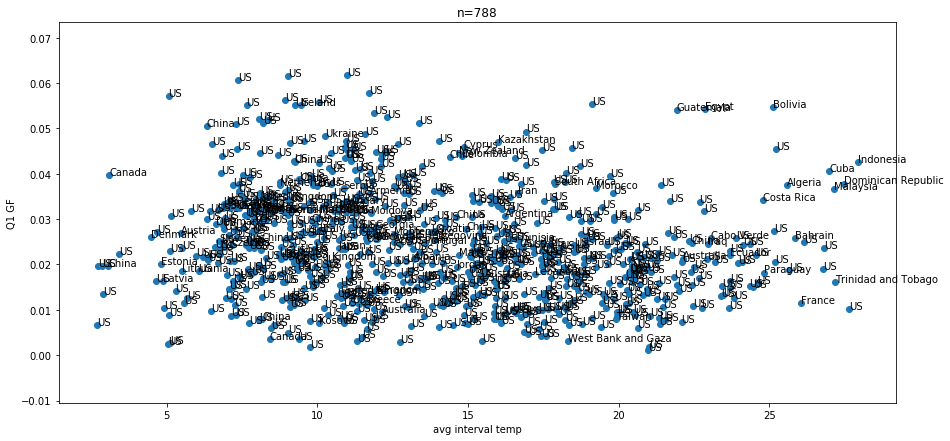

In [963]:
d = remove_outlier(DATA, (0.02, 0.98), ['GDP', 'Urbanization', 'avg_interval_tmp',\
                                     'GF_Q1', 'GF_Q2', 'GF_Q3'])

p_values = calc_corrs_scatter(d, plot=False, print_=False, only_us=False, return_p=True)
calc_corrs_scatter(d, plot=True, print_=True, only_us=False, show_names=True)

for p in p_values:
    print('FDR {0} pearson: {1}'.format(p, fdr(DATA, MINI_QUANTILES, p_values[p][0],\
                                               p, features=FEATURES)))
    print('FDR {0} spearman: {1}'.format(p, fdr(d, MINI_QUANTILES, p_values[p][1], p,\
                                                spearman=True, features=FEATURES)))

US

Interval temp vs GF_Q1 correlations
n=698
Pearson: -0.23674691854389873	One sided p_value: 1.1957616744819448e-10
Spearman: -0.24061244377768454	One sided p_value: 5.959372618551734e-11

Interval temp vs GF_Q2 correlations
n=698
Pearson: -0.1561595986768825	One sided p_value: 1.7084291729292783e-05
Spearman: -0.1715762946735783	One sided p_value: 2.5733775151129367e-06

Interval temp vs GF_Q3 correlations
n=698
Pearson: -0.11046855149294178	One sided p_value: 0.0017374941300007517
Spearman: -0.09848623785234856	One sided p_value: 0.004611918203054471

Interval temp vs adj_gf correlations
n=698
Pearson: -0.21721875954508402	One sided p_value: 3.3568655274674616e-09
Spearman: -0.21860334709938867	One sided p_value: 2.676547092846244e-09



-0.3624680379154518

FDR GF_Q1 pearson: 1.1957616744819448e-10
FDR GF_Q1 spearman: 5.959372618551734e-11
FDR GF_Q2 pearson: 1.7084291729292783e-05
FDR GF_Q2 spearman: 2.5733775151129367e-06
FDR GF_Q3 pearson: 0.0017374941300007517
FDR GF_Q3 spearman: 0.004611918203054471
FDR adj_gf pearson: 3.356865527467461e-09
FDR adj_gf spearman: 2.676547092846244e-09


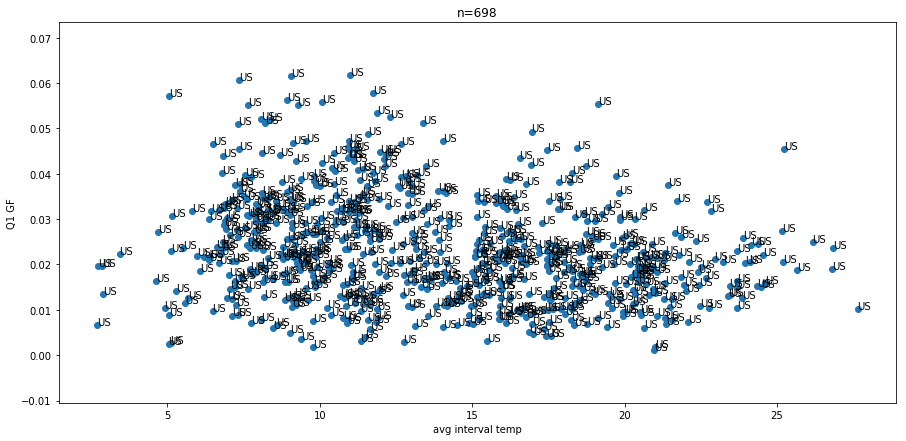

In [965]:
d = remove_outlier(DATA, (0.02, 0.98), FEATURES)

p_values = calc_corrs_scatter(d, plot=False, print_=False, only_us=True, return_p=True)
calc_corrs_scatter(d, plot=True, print_=True, only_us=True, show_names=True)

for p in p_values:
    print('FDR {0} pearson: {1}'.format(p, fdr(DATA[DATA['Country_Region']=='US'], MINI_QUANTILES, p_values[p][0],\
                                               p, features=FEATURES)))
    print('FDR {0} spearman: {1}'.format(p, fdr(d, MINI_QUANTILES, p_values[p][1],\
                                                p, spearman=True, features=FEATURES)))

#### OLD CODE TO SETUP NEW 2.5 DATA

In [905]:
hopkins_confirmed = pd.read_pickle('../augmented_datasets/pickles/final_data/hopkins_conf_full_0605_2.5percent.pkl')
to_drop = ['EXP_GF_Q1', 'EXP_GF_Q2', 'EXP_GF_Q3', 'EXP_GF_M01TO0',\
           'EXP_GF_0TO01', 'EXP_GF_01TO02', 'EXP_GF_02TO03', 'EXP_GF_03TO04',\
           'EXP_GF_ABOVE04', 'EXP_GF_ABOVE0', 'first_7', 'Total Tests', 'Max_Date']
hopkins_confirmed.drop(columns=to_drop, inplace=True)
hopkins_confirmed.drop((37.0902, -95.7129), level=0, inplace=True)

hopkins_confirmed.drop(columns='State Population', inplace=True)
hopkins_confirmed['Democracy'] = hopkins_confirmed['Democracy'].fillna(hopkins_confirmed['Democracy'].mean())
hopkins_confirmed['Tests \\ Pop'] = hopkins_confirmed['Tests \\ Pop'].fillna(0)
hopkins_confirmed['Province_State'] = hopkins_confirmed['Province_State'].fillna('')
hopkins_confirmed['Tests per 1M'] = hopkins_confirmed['Tests per 1M'].fillna(hopkins_confirmed['Tests per 1M'].mean())

In [906]:
# hopkins_confirmed.insert(2, 'adj_gf', np.nan)
hopkins_confirmed['adj_gf'] = ( (10**10) * hopkins_confirmed['GF_Q1']) / \
                             ((hopkins_confirmed['Median Age']) * hopkins_confirmed['Gini Index']\
                              * hopkins_confirmed['Democracy'] * (hopkins_confirmed['Tests per 1M']))
# Transpose Tests \\ pop to Test \\ million in US
hopkins_confirmed['Tests \\ Pop'] = hopkins_confirmed['Tests \\ Pop'] * 1e6

In [907]:
coords = set(hopkins_confirmed.index.get_level_values(0).tolist())
for coord in coords:
    try:
        last_rel_date = hopkins_confirmed.loc[coord]['last relevant date']['data']
        five_prcnt_date = hopkins_confirmed.loc[coord]['2.5%_Date']['data']

        five_prct_column = hopkins_confirmed.columns.get_loc(five_prcnt_date)
        last_rel_column = hopkins_confirmed.columns.get_loc(last_rel_date)
        interval = hopkins_confirmed[hopkins_confirmed.columns[five_prct_column:last_rel_column]]

        hopkins_confirmed.loc[coord, 'avg_interval_tmp']['data'] = interval.loc[coord].loc['avg_d_tmp'].mean(skipna=True)
        hopkins_confirmed.loc[coord, 'avg_interval_RH']['data'] = interval.loc[coord].loc['avg_d_RH'].mean(skipna=True)
        hopkins_confirmed.loc[coord, 'avg_mobility']['data'] = interval.loc[coord].loc['d_mob_change'].mean(skipna=True)
    except KeyError as e:
        print('key error, {0}'.format(coord))

key error, (38.02199522, -92.76083747)
key error, (43.95415864, -69.85074999)
key error, (44.0816316, -88.21780273)
key error, (38.26818502, -77.15852768)
key error, (44.89792533, -89.75863384)
key error, (-11.2027, 17.8739)
key error, (37.3080028, -79.5281964)
key error, (37.55531756, -79.80982182)
key error, (46.5107, -63.4168)
key error, (48.22390169, -101.5436763)
key error, (44.41464384, -98.27858469)
key error, (43.42406072, -82.82055898)
key error, (32.74255572, -101.9477242)
key error, (28.89333001, -98.52730485)
key error, (40.31123252, -86.05234925)
key error, (43.46492199, -89.33589004)
key error, (33.78290391, -82.74286107)
key error, (31.837258, -95.16559897)
key error, (48.54855019, -119.7387224)
key error, (30.79472531, -94.8276624)
key error, (30.74685667, -94.02667579)
key error, (31.55456473, -82.45936528)
key error, (31.92829517, -82.93491155)
key error, (37.10975748, -84.11321779)
key error, (37.71659336, -84.27220275)
key error, (37.9689263, -84.14615986)
key error

key error, (39.7420247, -84.64787018)
key error, (35.61318461, -95.37802952)
key error, (37.57250606, -105.7885451)
key error, (28.47048236, -96.61633945)
key error, (38.36176608, -82.68652187)
key error, (38.59743452, -82.53466552)
key error, (39.38154439, -94.77068479)
key error, (35.29631396, -90.77185818)
key error, (35.57433534, -90.66268713)
key error, (42.3665549, -123.5561938)
key error, (38.56443815, -95.28644341)
key error, (35.48508185, -81.21740317)
key error, (41.04658298, -100.7475374)
key error, (36.58006022, -105.6310198)
key error, (40.00522157, -78.48998442)
key error, (40.47961444, -78.34917412)
key error, (40.49527404, -78.71377428)
key error, (34.8932941, -76.54120135)
key error, (44.0636262, -83.89277559)
key error, (44.02238415, -92.86244324)
key error, (44.40849741, -92.7234195)
key error, (33.21570665, -97.65460265)
key error, (40.26186809, -96.68946704)
key error, (37.28131268, -76.70905141)
key error, (37.40809042, -76.53524337)
key error, (37.50694406, -76.9

In [908]:
hopkins_confirmed.dropna(subset=['GDP', 'Urbanization', 'Gini Index'], inplace=True)
hopkins_confirmed.dropna(inplace=True)